# Inicialização

## Prepara o ambiente local ou colab

In [4]:
# --- Detectar Ambiente (Colab ou Local) ---
IN_COLAB = False
try:
    # Tenta importar um módulo específico do Colab
    from google.colab import drive
    import shutil # Usaremos para copiar, se necessário, mas salvar direto é melhor
    import os

    try:
        drive.mount('/content/drive')
        # Crie um diretório específico para salvar os resultados desta execução
        save_base_dir = "/content/drive/MyDrive/GAN_Training_Results" # Ajuste o caminho como desejar
        os.makedirs(save_base_dir, exist_ok=True)
        # Opcional: Crie um subdiretório único para esta execução específica (ex: baseado em timestamp)
        # import datetime
        # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        # save_dir = os.path.join(save_base_dir, f"run_{timestamp}")
        # os.makedirs(save_dir, exist_ok=True)
        # Por simplicidade, vamos usar o diretório base diretamente por enquanto
        save_dir = save_base_dir
        print(f"✅ Google Drive montado. Arquivos serão salvos em: {save_dir}")
    except Exception as e:
        print(f"⚠️ Erro ao montar o Google Drive: {e}")
        print("   Downloads diretos serão tentados, mas podem atrasar.")
        save_dir = "." # Salvar localmente se o Drive falhar
    IN_COLAB = True
    print("✅ Ambiente Google Colab detectado. Downloads automáticos (a cada 2 épocas) ativados.")
except ImportError:
    print("✅ Ambiente local detectado. Downloads automáticos desativados.")

import os

✅ Ambiente local detectado. Downloads automáticos desativados.


## Importa Pacotes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Modelo Classificador

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Carrega Dados MNIST centralizado

In [3]:
BATCH_SIZE = 128

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the training and test datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainset_reduzido = torch.utils.data.random_split(trainset, [1000, len(trainset) - 1000])[0]
# Create data loaders
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
trainloader_reduzido = DataLoader(trainset_reduzido, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [ ]:
import matplotlib.pyplot as plt

# parameters
num_classes = 10
samples_per_class = 5

# containers
class_counts = {i: 0 for i in range(num_classes)}
class_images = {i: [] for i in range(num_classes)}

# gather up to 5 images per class
for img, label in trainset:
    if class_counts[label] < samples_per_class:
        class_images[label].append(img)
        class_counts[label] += 1
    # stop early once we have enough of every class
    if all(count >= samples_per_class for count in class_counts.values()):
        break

# plot
fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(5, 10))
for digit in range(num_classes):
    for i in range(samples_per_class):
        ax = axes[digit, i]
        ax.imshow(class_images[digit][i].squeeze(), cmap='gray')
        ax.axis('off')
    # label the rows on the leftmost subplot
    axes[digit, 0].set_ylabel(str(digit), rotation=0, labelpad=12, va='center', fontsize=12)

plt.suptitle("5 MNIST examples per digit (0–9)", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()


## Modelo Generativo

In [12]:
import numpy as np

### CGAN (simples, mlp)

In [9]:
class CGAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=100):
        super(CGAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.label_embedding = nn.Embedding(self.classes, self.classes)
        self.adv_loss = torch.nn.BCELoss()


        self.generator = nn.Sequential(
            *self._create_layer_gen(self.latent_dim + self.classes, 128, False),
            *self._create_layer_gen(128, 256),
            *self._create_layer_gen(256, 512),
            *self._create_layer_gen(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

        self.discriminator = nn.Sequential(
            *self._create_layer_disc(self.classes + int(np.prod(self.img_shape)), 1024, False, True),
            *self._create_layer_disc(1024, 512, True, True),
            *self._create_layer_disc(512, 256, True, True),
            *self._create_layer_disc(256, 128, False, False),
            *self._create_layer_disc(128, 1, False, False),
            nn.Sigmoid()
        )

    def _create_layer_gen(self, size_in, size_out, normalize=True):
        layers = [nn.Linear(size_in, size_out)]
        if normalize:
            layers.append(nn.BatchNorm1d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def _create_layer_disc(self, size_in, size_out, drop_out=True, act_func=True):
        layers = [nn.Linear(size_in, size_out)]
        if drop_out:
            layers.append(nn.Dropout(0.4))
        if act_func:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, input, labels):
        if input.dim() == 2:
            z = torch.cat((self.label_embedding(labels), input), -1)
            x = self.generator(z)
            x = x.view(x.size(0), *self.img_shape) #Em
            return x
        elif input.dim() == 4:
            x = torch.cat((input.view(input.size(0), -1), self.label_embedding(labels)), -1)
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)


### Arquitetura do paper F2U

In [13]:
class F2U_GAN(nn.Module):
    def __init__(self, dataset="mnist", img_size=28, latent_dim=128, condition=True):
        super(F2U_GAN, self).__init__()
        if dataset == "mnist":
            self.classes = 10
            self.channels = 1
        else:
            raise NotImplementedError("Only MNIST is supported")
        
        self.condition = condition
        self.label_embedding = nn.Embedding(self.classes, self.classes) if condition else None
        #self.label_embedding_disc = nn.Embedding(self.classes, self.img_size*self.img_size) if condition else None
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.img_shape = (self.channels, self.img_size, self.img_size)
        self.input_shape_gen = self.latent_dim + self.label_embedding.embedding_dim if condition else self.latent_dim
        self.input_shape_disc = self.channels + self.classes if condition else self.channels

        self.adv_loss = torch.nn.BCEWithLogitsLoss()

        # Generator (unchanged) To calculate output shape of convtranspose layers, we can use the formula:
        # output_shape = (input_shape - 1) * stride - 2 * padding + kernel_size + output_padding (or dilation * (kernel_size - 1) + 1 inplace of kernel_size if using dilation)
        self.generator = nn.Sequential(
            nn.Linear(self.input_shape_gen, 256 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # (256,7,7) -> (128,14,14)
            nn.BatchNorm2d(128, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # (128,14,14) -> (64,28,28)
            nn.BatchNorm2d(64, momentum=0.1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, self.channels, kernel_size=3, stride=1, padding=1), # (64,28,28) -> (1,28,28)
            nn.Tanh()
        )

        # Discriminator (corrected) To calculate output shape of conv layers, we can use the formula:
        # output_shape = ⌊(input_shape - kernel_size + 2 * padding) / stride + 1⌋ (or (dilation * (kernel_size - 1) - 1) inplace of kernel_size if using dilation)
        self.discriminator = nn.Sequential(
        # Camada 1: (1,28,28) -> (32,13,13)
        nn.utils.spectral_norm(nn.Conv2d(self.input_shape_disc, 32, kernel_size=3, stride=2, padding=0)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 2: (32,14,14) -> (64,7,7)
        nn.utils.spectral_norm(nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 3: (64,7,7) -> (128,3,3)
        nn.utils.spectral_norm(nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)),
        nn.LeakyReLU(0.2, inplace=True),

        # Camada 4: (128,3,3) -> (256,1,1)
        nn.utils.spectral_norm(nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=0)),  # Padding 0 aqui!
        nn.LeakyReLU(0.2, inplace=True),

        # Achata e concatena com as labels
        nn.Flatten(), # (256,1,1) -> (256*1*1,)
        nn.utils.spectral_norm(nn.Linear(256 * 1 * 1, 1))  # 256 (features)
        )

    def forward(self, input, labels=None):
        if input.dim() == 2:
            # Generator forward pass (unchanged)
            if self.condition:
                embedded_labels = self.label_embedding(labels)
                gen_input = torch.cat((input, embedded_labels), dim=1)
                x = self.generator(gen_input)
            else:
                x = self.generator(input)
            return x.view(-1, *self.img_shape)

        elif input.dim() == 4:
            # Discriminator forward pass
            if self.condition:
                embedded_labels = self.label_embedding(labels)
                image_labels = embedded_labels.view(embedded_labels.size(0), self.label_embedding.embedding_dim, 1, 1).expand(-1, -1, self.img_size, self.img_size)
                x = torch.cat((input, image_labels), dim=1)
            else:
                x = input
            return self.discriminator(x)

    def loss(self, output, label):
        return self.adv_loss(output, label)

## Funções para geração de dataset e imagens

In [14]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import random # Needed for handling remainders if samples aren't perfectly divisible

class GeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=100,
                 num_classes=10, # Total classes the generator model knows
                 desired_classes=None, # Optional: List of specific class indices to generate
                 device="cpu",
                 image_col_name="image",
                 label_col_name="label"):
        """
        Generates a dataset using a conditional generative model, potentially
        focusing on a subset of classes.

        Args:
            generator: The pre-trained generative model.
            num_samples (int): Total number of images to generate across the desired classes.
            latent_dim (int): Dimension of the latent space vector (z).
            num_classes (int): The total number of classes the generator was trained on.
                               This is crucial for correct label conditioning (e.g., one-hot dim).
            desired_classes (list[int], optional): A list of integer class indices to generate.
                                                  If None or empty, images for all classes
                                                  (from 0 to num_classes-1) will be generated,
                                                  distributed as evenly as possible.
                                                  Defaults to None.
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
            label_col_name (str): Name for the label column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        # Store the total number of classes the generator understands
        self.total_num_classes = num_classes
        self.device = device
        self.model_type = type(self.generator).__name__ # Get generator class name
        self.image_col_name = image_col_name
        self.label_col_name = label_col_name

        # Determine the actual classes to generate based on desired_classes
        if desired_classes is not None and len(desired_classes) > 0:
            # Validate that desired classes are within the generator's known range
            if not all(0 <= c < self.total_num_classes for c in desired_classes):
                raise ValueError(f"All desired classes must be integers between 0 and {self.total_num_classes - 1}")
            # Use only the unique desired classes, sorted for consistency
            self._actual_classes_to_generate = sorted(list(set(desired_classes)))
        else:
            # If no specific classes desired, generate all classes
            self._actual_classes_to_generate = list(range(self.total_num_classes))

        # The 'classes' attribute of the dataset reflects only those generated
        self.classes = self._actual_classes_to_generate
        self.num_generated_classes = len(self.classes) # Number of classes being generated

        if self.num_generated_classes == 0 and self.num_samples > 0:
             raise ValueError("Cannot generate samples with an empty list of desired classes.")
        elif self.num_samples == 0:
             print("Warning: num_samples is 0. Dataset will be empty.")
             self.images = torch.empty(0) # Adjust shape if known
             self.labels = torch.empty(0, dtype=torch.long)
        else:
             # Generate the data only if needed
             self.images, self.labels = self.generate_data()


    def generate_data(self):
        """Generates images and corresponding labels for the specified classes."""
        self.generator.eval()
        self.generator.to(self.device)

        # --- Create Labels ---
        generated_labels_list = []
        if self.num_generated_classes > 0:
            # Distribute samples as evenly as possible among the desired classes
            samples_per_class = self.num_samples // self.num_generated_classes
            for cls in self._actual_classes_to_generate:
                generated_labels_list.extend([cls] * samples_per_class)

            # Handle remaining samples if num_samples is not perfectly divisible
            num_remaining = self.num_samples - len(generated_labels_list)
            if num_remaining > 0:
                # Add remaining samples by randomly choosing from the desired classes
                remainder_labels = random.choices(self._actual_classes_to_generate, k=num_remaining)
                generated_labels_list.extend(remainder_labels)

            # Shuffle labels for better distribution in batches later
            random.shuffle(generated_labels_list)

        # Convert labels list to tensor
        labels = torch.tensor(generated_labels_list, dtype=torch.long, device=self.device)

        # Double check label count (should match num_samples due to logic above)
        if len(labels) != self.num_samples:
             # This indicates an unexpected issue, potentially if num_generated_classes was 0 initially
             # but num_samples > 0. Raise error or adjust. Let's adjust defensively.
             print(f"Warning: Label count mismatch. Expected {self.num_samples}, got {len(labels)}. Adjusting size.")
             if len(labels) > self.num_samples:
                 labels = labels[:self.num_samples]
             else:
                 # Pad if too few (less likely with current logic unless num_generated_classes=0)
                 num_needed = self.num_samples - len(labels)
                 if self.num_generated_classes > 0:
                      padding = torch.tensor(random.choices(self._actual_classes_to_generate, k=num_needed), dtype=torch.long, device=self.device)
                      labels = torch.cat((labels, padding))
                 # If no classes to generate from, labels tensor might remain smaller

        # --- Create Latent Noise ---
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # --- Generate Images in Batches ---
        generated_images_list = []
        # Consider making batch_size configurable
        batch_size = min(1024, self.num_samples) if self.num_samples > 0 else 1

        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                labels_batch = labels[i : min(i + batch_size, self.num_samples)]

                # Skip if batch is empty (can happen if num_samples = 0)
                if z_batch.shape[0] == 0:
                    continue

                # --- Condition the generator based on its type ---
                if self.model_type == 'Generator': # Assumes input: concat(z, one_hot_label)
                    # One-hot encode labels using the TOTAL number of classes the generator knows
                    labels_one_hot_batch = F.one_hot(labels_batch, num_classes=self.total_num_classes).float()
                    generator_input = torch.cat([z_batch, labels_one_hot_batch], dim=1)
                    gen_imgs = self.generator(generator_input)
                elif self.model_type == 'CGAN' or self.model_type == "F2U_GAN": # Assumes input: z, label_index
                    gen_imgs = self.generator(z_batch, labels_batch)
                else:
                    # Handle other potential generator architectures or raise an error
                    raise NotImplementedError(f"Generation logic not defined for model type: {self.model_type}")

                generated_images_list.append(gen_imgs.cpu()) # Move generated images to CPU

        self.generator.cpu() # Move generator back to CPU after generation

        # Concatenate all generated image batches
        if generated_images_list:
            all_gen_imgs = torch.cat(generated_images_list, dim=0)
        else:
            # If no images were generated (e.g., num_samples = 0)
            # Create an empty tensor. Shape needs care - determine from generator or use placeholder.
            # Let's attempt a placeholder [0, C, H, W] - requires knowing C, H, W.
            # For now, a simple empty tensor. User might need to handle this downstream.
            print("Warning: No images generated. Returning empty tensor for images.")
            all_gen_imgs = torch.empty(0)

        return all_gen_imgs, labels.cpu() # Return images and labels (on CPU)

    def __len__(self):
        # Return the actual number of samples generated
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return {
            self.image_col_name: self.images[idx],
            self.label_col_name: int(self.labels[idx]) # Return label as standard Python int
        }


In [9]:
class UnconditionalGeneratedDataset(Dataset):
    def __init__(self,
                 generator,
                 num_samples,
                 latent_dim=128,
                 device="cpu",
                 image_col_name="image"):
        """
        Generates a dataset using an unconditional generative model.

        Args:
            generator: The pre-trained unconditional generative model.
            num_samples (int): Total number of images to generate.
            latent_dim (int): Dimension of the latent space vector (z).
            device (str): Device to run generation on ('cpu' or 'cuda').
            image_col_name (str): Name for the image column in the output dictionary.
        """
        self.generator = generator
        self.num_samples = num_samples
        self.latent_dim = latent_dim
        self.device = device
        self.image_col_name = image_col_name

        if self.num_samples < 0:
            raise ValueError("num_samples must be non-negative")
        elif self.num_samples == 0:
            print("Warning: num_samples is 0. Dataset will be empty.")
            self.images = torch.empty(0)
        else:
            self.images = self._generate_images()

    def _generate_images(self):
        self.generator.eval()
        self.generator.to(self.device)

        # Create latent noise
        z = torch.randn(self.num_samples, self.latent_dim, device=self.device)

        # Generate images in batches
        generated_images = []
        batch_size = min(1024, self.num_samples)
        with torch.no_grad():
            for i in range(0, self.num_samples, batch_size):
                z_batch = z[i : min(i + batch_size, self.num_samples)]
                gen_imgs = self.generator(z_batch)
                generated_images.append(gen_imgs.cpu())

        self.generator.cpu()
        return torch.cat(generated_images, dim=0)

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Dataset index out of range")
        return { self.image_col_name: self.images[idx] }


In [15]:
def generate_plot(net, device, round_number, client_id = None, examples_per_class: int=5, classes: int=10, latent_dim: int=100, server: bool=False):
    """Gera plot de imagens de cada classe"""
    if server:
        import matplotlib
        matplotlib.use("Agg")
        import matplotlib.pyplot as plt
    else:
        import matplotlib.pyplot as plt

    net_type = type(net).__name__
    net.to(device)
    net.eval()
    batch_size = examples_per_class * classes

    latent_vectors = torch.randn(batch_size, latent_dim, device=device)
    labels = torch.tensor([i for i in range(classes) for _ in range(examples_per_class)], device=device)

    with torch.no_grad():
        if net_type == "Generator":
            labels_one_hot = torch.nn.functional.one_hot(labels, 10).float().to(device)
            generated_images = net(torch.cat([latent_vectors, labels_one_hot], dim=1))
        else:
            generated_images = net(latent_vectors, labels)

    # Criar uma figura com 10 linhas e 5 colunas de subplots
    fig, axes = plt.subplots(classes, examples_per_class, figsize=(5, 9))

    # Adiciona título no topo da figura
    if isinstance(client_id, int):
        fig.text(0.5, 0.98, f"Round: {round_number} | Client: {client_id}", ha="center", fontsize=12)
    else:
        fig.text(0.5, 0.98, f"Round: {round_number}", ha="center", fontsize=12)

    # Exibir as imagens nos subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i, 0, :, :], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    # Ajustar o layout antes de calcular as posições
    plt.tight_layout(rect=[0.05, 0, 1, 0.96])

    # Reduzir espaço entre colunas
    # plt.subplots_adjust(wspace=0.05)

    # Adicionar os rótulos das classes corretamente alinhados
    fig.canvas.draw()  # Atualiza a renderização para obter posições corretas
    for row in range(classes):
        # Obter posição do subplot em coordenadas da figura
        bbox = axes[row, 0].get_window_extent(fig.canvas.get_renderer())
        pos = fig.transFigure.inverted().transform([(bbox.x0, bbox.y0), (bbox.x1, bbox.y1)])
        center_y = (pos[0, 1] + pos[1, 1]) / 2  # Centro exato da linha

        # Adicionar o rótulo
        fig.text(0.04, center_y, str(row), va='center', fontsize=12, color='black')

    IN_COLAB = False
    try:
        # Tenta importar um módulo específico do Colab
        import google.colab
        IN_COLAB = True
    except:
        pass
    if IN_COLAB:
        if isinstance(client_id, int):
            fig.savefig(os.path.join(save_dir, f"mnist_{net_type}_r{round_number}_c{client_id}.png"))
            print("Imagem do cliente salva no drive")
        else:
            fig.savefig(os.path.join(save_dir, f"mnist_{net_type}_r{round_number}.png"))
            print("Imagem do servidor salva no drive")
    else:
        if isinstance(client_id, int):
            fig.savefig(f"mnist_{net_type}_r{round_number}_c{client_id}.png")
            print("Imagem do cliente salva")
        else:
            fig.savefig(f"mnist_{net_type}_r{round_number}.png")
            print("Imagem do servidor salva")
    plt.close(fig)
    return

In [10]:
def plot_unconditional_generated(
        generator,
        device,
        total_samples,
        samples_per_row=5,
        latent_dim=100,
        save_path=None,
        round_number=None):
    """
    Generates and plots images from an unconditional generator in a grid.

    Args:
        generator: The unconditional torch generator model (z -> image).
        device: Device to run generation on ('cpu' or 'cuda').
        total_samples (int): Number of images to generate.
        samples_per_row (int): Number of images per row in the grid.
        latent_dim (int): Dimension of latent vector.
        save_path (str, optional): Filepath to save the figure. If None, just shows plot.
    """

    generator.eval()
    generator.to(device)

    # Sample latent vectors
    z = torch.randn(total_samples, latent_dim, device=device)
    with torch.no_grad():
        imgs = generator(z)

    # Determine grid size
    cols = samples_per_row
    rows = math.ceil(total_samples / cols)

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(cols-2*cols/(rows+cols), rows-1*rows/(rows+cols)))
    axes = axes.flatten() if total_samples > 1 else [axes]

    fig.text(0.5, 0.99, f"Round: {round_number}", ha="center", fontsize=11)

    for idx in range(rows * cols):
        ax = axes[idx]
        ax.axis('off')
        if idx < total_samples:
            img = imgs[idx]
            # Assume (C, H, W) and single-channel
            ax.imshow(img[0], cmap='gray')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path)
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

    plt.close(fig)


## Importa Pacotes Federado

In [11]:
if IN_COLAB:
    !pip install flwr_datasets

In [ ]:
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner, ShardPartitioner
from flwr_datasets.visualization import plot_label_distributions
from flwr_datasets import FederatedDataset

## Particionador por classes

In [13]:
# Copyright 2023 Flower Labs GmbH. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Class-based partitioner for Hugging Face Datasets."""


from collections import defaultdict
import random
from typing import Optional, List
import numpy as np
from datasets import Dataset
from flwr_datasets.partitioner.partitioner import Partitioner  # Assuming this is in the package structure


class ClassPartitioner(Partitioner):
    """Partitions a dataset by class, ensuring each class appears in exactly one partition.

    Attributes:
        num_partitions (int): Total number of partitions to create
        seed (int, optional): Random seed for reproducibility
        label_column (str): Name of the column containing class labels
    """

    def __init__(
        self,
        num_partitions: int,
        seed: Optional[int] = None,
        label_column: str = "label"
    ) -> None:
        super().__init__()
        self._num_partitions = num_partitions
        self._seed = seed
        self._label_column = label_column
        self._partition_indices: Optional[List[List[int]]] = None

    def _create_partitions(self) -> None:
        """Create class-based partitions and store indices."""
        # Extract labels from dataset
        labels = self.dataset[self._label_column]

        # Group indices by class
        class_indices = defaultdict(list)
        for idx, label in enumerate(labels):
            class_indices[label].append(idx)

        classes = list(class_indices.keys())
        num_classes = len(classes)

        # Validate number of partitions
        if self._num_partitions > num_classes:
            raise ValueError(
                f"Cannot create {self._num_partitions} partitions with only {num_classes} classes. "
                f"Reduce partitions to ≤ {num_classes}."
            )

        # Shuffle classes for random distribution
        rng = random.Random(self._seed)
        rng.shuffle(classes)

        # Split classes into partitions
        partition_classes = np.array_split(classes, self._num_partitions)

        # Create index lists for each partition
        self._partition_indices = []
        for class_group in partition_classes:
            indices = []
            for cls in class_group:
                indices.extend(class_indices[cls])
            self._partition_indices.append(indices)

    @property
    def dataset(self) -> Dataset:
        return super().dataset

    @dataset.setter
    def dataset(self, value: Dataset) -> None:
        # Use parent setter for basic validation
        super(ClassPartitioner, ClassPartitioner).dataset.fset(self, value)

        # Create partitions once dataset is set
        self._create_partitions()

    def load_partition(self, partition_id: int) -> Dataset:
        """Load a partition containing exclusive classes.

        Args:
            partition_id: The ID of the partition to load (0-based index)

        Returns:
            Dataset: Subset of the dataset containing only the specified partition's data
        """
        if not self.is_dataset_assigned():
            raise RuntimeError("Dataset must be assigned before loading partitions")
        if partition_id < 0 or partition_id >= self.num_partitions:
            raise ValueError(f"Invalid partition ID: {partition_id}")

        return self.dataset.select(self._partition_indices[partition_id])

    @property
    def num_partitions(self) -> int:
        return self._num_partitions

    def __repr__(self) -> str:
        return (f"ClassPartitioner(num_partitions={self._num_partitions}, "
                f"seed={self._seed}, label_column='{self._label_column}')")

## Carrega e divide dados entre clientes

In [46]:
num_partitions = 5
alpha_dir = 0.1

Rodar somente o particionador desejado

In [15]:
partitioner = ClassPartitioner(num_partitions=num_partitions, seed=42, label_column="label")

In [ ]:
partitioner = DirichletPartitioner(
    num_partitions=num_partitions,
    partition_by="label",
    alpha=alpha_dir,
    min_partition_size=0,
    self_balancing=False
)

In [47]:
partitioner = IidPartitioner(
    num_partitions=num_partitions
)

In [48]:
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": partitioner}
)

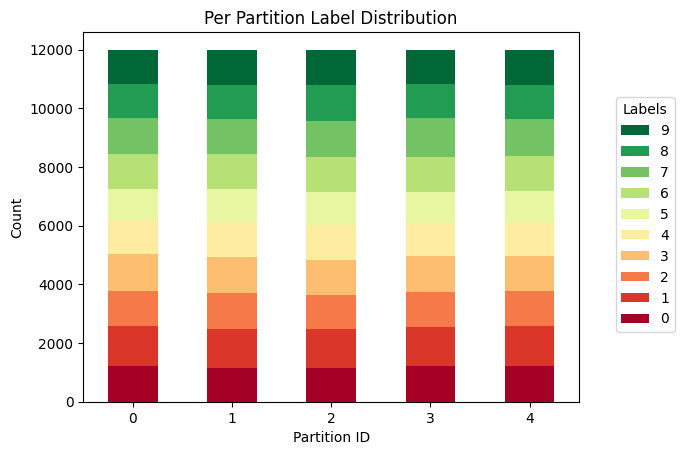

In [49]:
partitioner = fds.partitioners["train"]
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    title="Per Partition Label Distribution",
    legend=True,
    verbose_labels=True,
    size_unit="absolute",
    partition_id_axis="x",
)

In [50]:
train_partitions = [fds.load_partition(i, split="train") for i in range(num_partitions)]

In [51]:
from torchvision.transforms import Compose, ToTensor, Normalize

In [52]:
pytorch_transforms = Compose([
    ToTensor(),
    Normalize((0.5,), (0.5,))
])

def apply_transforms(batch):
    batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
    return batch

In [53]:
train_partitions = [train_partition.with_transform(apply_transforms) for train_partition in train_partitions]

In [54]:
batch_size = 64
trainloaders = [DataLoader(train_partition, batch_size=batch_size, shuffle=True) for train_partition in train_partitions]

## Inicializa modelos e otimizadores

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Rodar somente o modelo desejado

In [ ]:
models = [CGAN() for i in range(num_partitions)]
gen = CGAN().to(device)
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [55]:
models = [F2U_GAN(condition=True) for i in range(num_partitions)]	
gen = F2U_GAN(condition=True).to(device)
optim_G = torch.optim.Adam(gen.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [56]:
optim_Ds = [
    torch.optim.Adam(model.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    for model in models
]

# scheduler_D = torch.optim.lr_scheduler.StepLR(optim_D, step_size=5, gamma=0.9)
# scheduler_G = torch.optim.lr_scheduler.StepLR(optim_G, step_size=5, gamma=0.9)

# Treinamento dos modelos

## Cria chunks para o treinamento alternado entre discriminadora e geradora ser mais constante.

In [26]:
from tqdm.notebook import tqdm
import time

In [27]:
import math
from torch.utils.data import Subset

Quanto menos chunks, mais dados em cada chunk e mais dados são treinados na discriminadora antes de treinar a geradora. No paper do F2U, não está claro como os treinamentos são alternados. 

In [57]:
num_chunks = 100
client_chunks = []
for train_partition in train_partitions:
  chunk_size = math.ceil(len(train_partition)/num_chunks)

  chunks = []
  for i in range(num_chunks):
      start = i * chunk_size
      end = min((i + 1) * chunk_size, len(train_partition))
      chunks.append(Subset(train_partition, range(start, end)))

  client_chunks.append(chunks)

## Treinamento

In [30]:
from collections import defaultdict
import os
import json

Não esquecer de reinicializar os modelos e otimizadores se for reinicializar o treinamento.

In [ ]:
wgan = False
epochs = 55
losses_dict = {"g_losses_chunk": [],
               "d_losses_chunk": [],
               "g_losses_round": [],
               "d_losses_round": []}
accuracies = []

epoch_bar = tqdm(range(epochs), desc="Treinamento", leave=True, position=0)

batch_size_gen = 4
batch_tam = 64
extra_g_e = 4
latent_dim = 128

if IN_COLAB:
  acc_filename = os.path.join(save_dir,"accuracy_report.txt")
  loss_filename = os.path.join(save_dir, "losses.json")
else:
  acc_filename = "accuracy_report.txt"
  loss_filename = "losses.json"



for epoch in epoch_bar:
  g_loss_c = 0.0
  d_loss_c = 0.0
  total_d_samples = 0  # Amostras totais processadas pelos discriminadores
  total_g_samples = 0  # Amostras totais processadas pelo gerador

  chunk_bar = tqdm(range(num_chunks), desc="Chunks", leave=False, position=1)

  for chunk_idx in chunk_bar:
    # ====================================================================
    # Treino dos Discriminadores (clientes) no bloco atual
    # ====================================================================
    d_loss_b = 0
    total_chunk_samples = 0

    client_bar = tqdm(enumerate(zip(models, client_chunks)), desc="Clients", leave=False, position=2)

    for i, (net, chunks) in client_bar:
      # Carregar o bloco atual do cliente
      chunk_dataset = chunks[chunk_idx]
      if len(chunk_dataset) == 0:
         continue
      chunk_loader = DataLoader(chunk_dataset, batch_size=batch_tam, shuffle=True)

      # Treinar o discriminador no bloco
      net.to(device)
      gen.to(device)
      optim_D = optim_Ds[i]

      batch_bar = tqdm(chunk_loader, desc="Batches", leave=False, position=3)

      for batch in batch_bar:
          images, labels = batch["image"].to(device), batch["label"].to(device)
          batch_size = images.size(0)
          if batch_size == 1:
            continue
          real_ident = torch.full((batch_size, 1), 1., device=device)
          fake_ident = torch.full((batch_size, 1), 0., device=device)

          z_noise = torch.randn(batch_size, latent_dim, device=device)
          x_fake_labels = torch.randint(0, 10, (batch_size,), device=device)

          # Train D
          optim_D.zero_grad()

          if wgan:
            labels = torch.nn.functional.one_hot(labels, 10).float().to(device)
            x_fake_l = torch.nn.functional.one_hot(x_fake_labels, 10).float()

            # Adicionar labels ao images para treinamento do Discriminador
            image_labels = labels.view(labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
            image_fake_labels = x_fake_l.view(x_fake_l.size(0), 10, 1, 1).expand(-1, -1, 28, 28)

            images = torch.cat([images, image_labels], dim=1)

            # Treinar Discriminador
            z = torch.cat([z_noise, x_fake_l], dim=1)
            fake_images = gen(z).detach()
            fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

            d_loss = discriminator_loss(net(images), net(fake_images)) + 10 * gradient_penalty(net, images, fake_images)

          else:
            # Dados Reais
            y_real = net(images, labels)
            d_real_loss = net.loss(y_real, real_ident)

            # Dados Falsos
            x_fake = gen(z_noise, x_fake_labels).detach()
            y_fake_d = net(x_fake, x_fake_labels)
            d_fake_loss = net.loss(y_fake_d, fake_ident)

            # Loss total e backprop
            d_loss = (d_real_loss + d_fake_loss) / 2

          d_loss.backward()
          #torch.nn.utils.clip_grad_norm_(net.discriminator.parameters(), max_norm=1.0)
          optim_D.step()
          d_loss_b += d_loss.item()
          total_chunk_samples += 1
    # Média da perda dos discriminadores neste chunk
    avg_d_loss_chunk = d_loss_b / total_chunk_samples if total_chunk_samples > 0 else 0.0
    losses_dict["d_losses_chunk"].append(avg_d_loss_chunk)
    d_loss_c += avg_d_loss_chunk * total_chunk_samples
    total_d_samples += total_chunk_samples

    chunk_g_loss = 0.0

    epoch_gen_bar = tqdm(range(extra_g_e), desc="Gerador", leave=False, position=2)

    for g_epoch in epoch_gen_bar:
      # Train G
      optim_G.zero_grad()

      # Gera dados falsos
      z_noise = torch.randn(batch_size_gen, latent_dim, device=device)
      x_fake_labels = torch.randint(0, 10, (batch_size_gen,), device=device)

      if wgan:
        x_fake_labels = torch.nn.functional.one_hot(x_fake_labels, 10).float()
        z_noise = torch.cat([z_noise, x_fake_labels], dim=1)
        fake_images = gen(z_noise)

        # Seleciona o melhor discriminador (Dmax)
        image_fake_labels = x_fake_labels.view(x_fake_labels.size(0), 10, 1, 1).expand(-1, -1, 28, 28)
        fake_images = torch.cat([fake_images, image_fake_labels], dim=1)

        y_fake_gs = [model(fake_images.detach()) for model in models]

      else:
        x_fake = gen(z_noise, x_fake_labels)

        # Seleciona o melhor discriminador (Dmax)
        y_fake_gs = [model(x_fake.detach(), x_fake_labels) for model in models]

      y_fake_g_means = [torch.mean(y).item() for y in y_fake_gs]
      Dmax = models[y_fake_g_means.index(max(y_fake_g_means))]

      # Calcula a perda do gerador
      real_ident = torch.full((batch_size_gen, 1), 1., device=device)
      if wgan:
        y_fake_g = Dmax(fake_images)
        g_loss = generator_loss(y_fake_g)

      else:
        y_fake_g = Dmax(x_fake, x_fake_labels)  # Detach explícito
        g_loss = gen.loss(y_fake_g, real_ident)

      g_loss.backward()
      #torch.nn.utils.clip_grad_norm_(gen.generator.parameters(), max_norm=1.0)
      optim_G.step()

      chunk_g_loss += g_loss.item()
    losses_dict["g_losses_chunk"].append(chunk_g_loss / extra_g_e)
    g_loss_c += chunk_g_loss /extra_g_e

  g_loss_e = g_loss_c/num_chunks
  d_loss_e = d_loss_c / total_d_samples if total_d_samples > 0 else 0.0

  losses_dict["g_losses_round"].append(g_loss_e)
  losses_dict["d_losses_round"].append(d_loss_e)
  if (epoch+1)%2==0:
    model_filename = f"gen_round{epoch+1}.pt"
    if IN_COLAB:
        model_filename = os.path.join(save_dir, model_filename)
    torch.save(gen.state_dict(), model_filename)
    # generate_plot(net=gen, device="cpu", round_number=epoch+1, latent_dim=latent_dim)
    # generated_dataset = GeneratedDataset(generator=gen.to("cpu"), num_samples=12000, latent_dim=latent_dim, num_classes=10, device="cpu")
    # generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=True)
    # print("Treinando modelo classificador")
    # net = Net().to(device)
    # criterion = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    # net.train()
    # for epoch in range(5):
    #     for data in generated_dataloader:
    #         inputs, labels = data["image"].to(device), data["label"].to(device)
    #         optimizer.zero_grad()
    #         outputs = net(inputs)
    #         loss = criterion(outputs, labels)
    #         loss.backward()
    #         optimizer.step()
    # correct, loss = 0, 0.0

    # # Initialize counters
    # num_classes = 10  # Update with your actual number of classes
    # class_correct = defaultdict(int)
    # class_total = defaultdict(int)
    # predictions_counter = defaultdict(int)

    # # Evaluation
    # net.eval()
    # with torch.no_grad():
    #     for batch in testloader:
    #         images, labels = batch[0].to(device), batch[1].to(device)
    #         outputs = net(images)
    #         _, predicted = torch.max(outputs, 1)

    #         # Update counts for each sample in batch
    #         for true_label, pred_label in zip(labels, predicted):
    #             true_idx = true_label.item()
    #             pred_idx = pred_label.item()

    #             class_total[true_idx] += 1
    #             predictions_counter[pred_idx] += 1

    #             if true_idx == pred_idx:
    #                 class_correct[true_idx] += 1

    # # Create results dictionary
    # results = {
    #     "class_metrics": {},
    #     "overall_accuracy": None,
    #     "prediction_distribution": dict(predictions_counter)
    # }

    # # Calculate class-wise metrics
    # for i in range(num_classes):
    #     metrics = {
    #         "samples": class_total[i],
    #         "predictions": predictions_counter[i],
    #         "accuracy": class_correct[i] / class_total[i] if class_total[i] > 0 else "N/A"
    #     }
    #     results["class_metrics"][f"class_{i}"] = metrics

    # # Calculate overall accuracy
    # total_samples = sum(class_total.values())
    # results["overall_accuracy"] = sum(class_correct.values()) / total_samples
    # accuracies.append(results["overall_accuracy"])

    # # Save to txt file
    # with open(acc_filename, "a") as f:
    #     # Header with fixed widths
    #     f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
    #         "Class", "Accuracy", "Samples", "Predictions"))
    #     f.write("-"*45 + "\n")

    #     # Class rows with consistent formatting
    #     for cls in range(num_classes):
    #         metrics = results["class_metrics"][f"class_{cls}"]

    #         # Format accuracy (handle "N/A" case)
    #         accuracy = (f"{metrics['accuracy']:.4f}"
    #                   if isinstance(metrics['accuracy'], float)
    #                   else "  N/A  ")

    #         f.write("{:<10} {:<10} {:<10} {:<10}\n".format(
    #             f"Class {cls}",
    #             accuracy,
    #             metrics['samples'],
    #             metrics['predictions']
    #         ))

    #     # Footer with alignment
    #     f.write("\n{:<20} {:.4f}".format("Overall Accuracy:", results["overall_accuracy"]))
    #     f.write("\n{:<20} {}".format("Total Samples:", total_samples))
    #     f.write("\n{:<20} {}".format("Total Predictions:", sum(predictions_counter.values())))

    # print("Results saved to accuracy_report.txt")


  print(f"Época {epoch+1} completa")

  try:
      with open(loss_filename, 'w', encoding='utf-8') as f:
          json.dump(losses_dict, f, ensure_ascii=False, indent=4) # indent makes it readable
      print(f"Losses dict successfully saved to {loss_filename}")
  except Exception as e:
      print(f"Error saving losses dict to JSON: {e}")

# Gráficos de perda e acurácia

## Le o arquivo de perda salvo no treinamento

In [59]:
try:
    with open(loss_filename, 'r', encoding='utf-8') as f:
        # The load function also works the same
        loaded_dict = json.load(f)
    print(f"Dictionary successfully loaded from {loss_filename}")
    print("Loaded dictionary:", loaded_dict)
    # Check type and access an element
    print("Type of loaded data:", type(loaded_dict))
    if isinstance(loaded_dict, dict):
        print("Value for key 'name':", loaded_dict.get("name")) # Use .get for safe access
        print("Value for key 'details':", loaded_dict.get("details"))
except FileNotFoundError:
    print(f"Error: File '{loss_filename}' not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from '{loss_filename}'. File might be corrupted or not JSON.")
except Exception as e:
    print(f"Error loading dictionary from JSON: {e}")

Dictionary successfully loaded from losses.json
Loaded dictionary: {'g_losses_chunk': [0.5723418891429901, 0.5895018130540848, 0.6327382624149323, 0.7020055949687958, 0.6244866028428078, 0.7681022733449936, 0.9989940375089645, 1.1887362003326416, 1.4107951521873474, 1.641440212726593, 1.9275420308113098, 1.3070645183324814, 1.4188311696052551, 1.5357431918382645, 1.675196886062622, 1.266333818435669, 1.7061452269554138, 1.8325019478797913, 1.9761877357959747, 2.21942937374115, 2.1241080164909363, 1.8457671254873276, 1.4127709865570068, 1.415366381406784, 1.590353786945343, 1.2531967759132385, 1.7658345699310303, 1.800956904888153, 2.220038264989853, 2.199747622013092, 2.600722074508667, 2.5133031010627747, 2.834033787250519, 2.768334448337555, 3.0801073908805847, 3.052626609802246, 3.250673294067383, 3.2169368267059326, 3.1717060208320618, 3.3800697922706604, 3.3252129554748535, 3.419889509677887, 3.5738964080810547, 3.7354235649108887, 3.851470112800598, 3.87734591960907, 3.9810811877

## Exibe gráficos

In [34]:
import matplotlib.pyplot as plt

In [35]:
def loss_graph(g_losses: int, d_losses: int) -> None:
    """Funcao para gerar grafico de evolucao das perdas da geradora e discriminadora"""

    # Número de iterações/épocas para cada lista
    epochs_g = range(len(g_losses))  # Eixo x para o gerador
    epochs_d = range(len(d_losses))  # Eixo x para o discriminador

    # Criar o gráfico
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_g, g_losses, label='Generator Loss')
    plt.plot(epochs_d, d_losses, label='Discriminator Loss')

    # Adicionar título e rótulos aos eixos
    plt.title('Generator and Discriminator Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Mostrar o gráfico
    plt.show()

In [ ]:
# Find the index and value of the maximum accuracy
max_index = accuracies.index(max(accuracies))
max_accuracy = accuracies[max_index]

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(len(accuracies)), accuracies, label="Accuracy", marker='o')

# Highlight the maximum accuracy point
plt.scatter(max_index, max_accuracy, color='red', label=f"Max Accuracy: {max_accuracy:.4f}")
plt.annotate(f"{max_accuracy:.4f}", (max_index, max_accuracy), textcoords="offset points", xytext=(0, 10), ha='center')

# Add labels, title, and legend
plt.title("Accuracy Over Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy")

# Show the plot
plt.show()

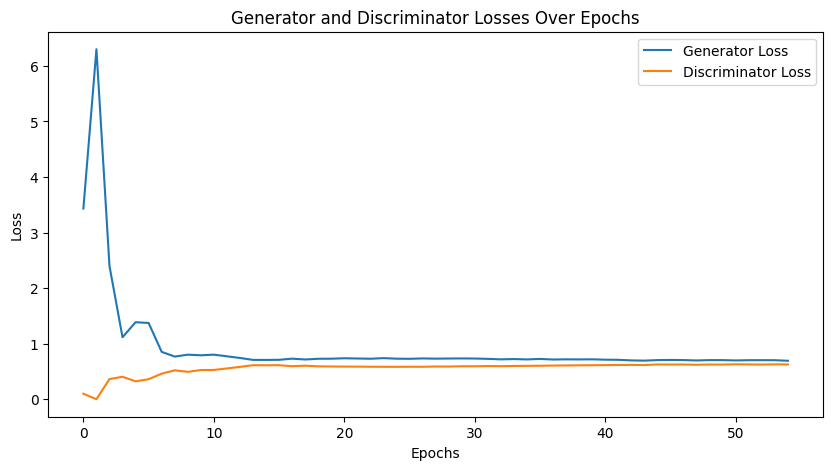

In [60]:
loss_graph(g_losses=loaded_dict["g_losses_round"], d_losses=loaded_dict["d_losses_round"])

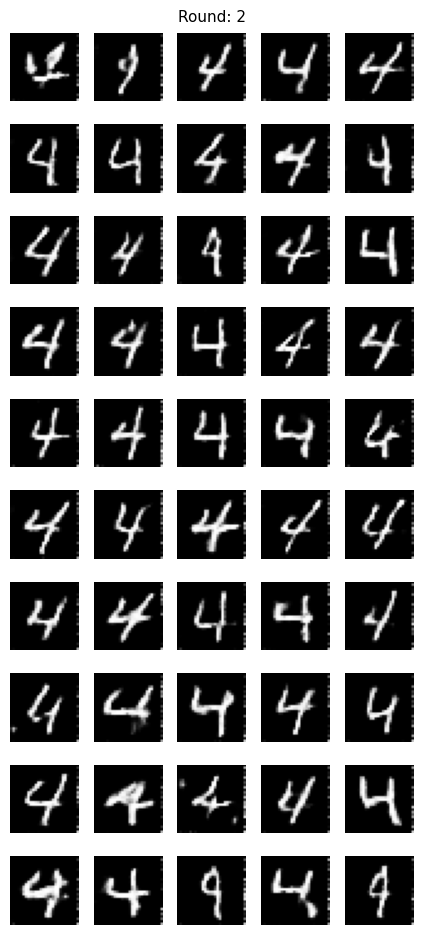

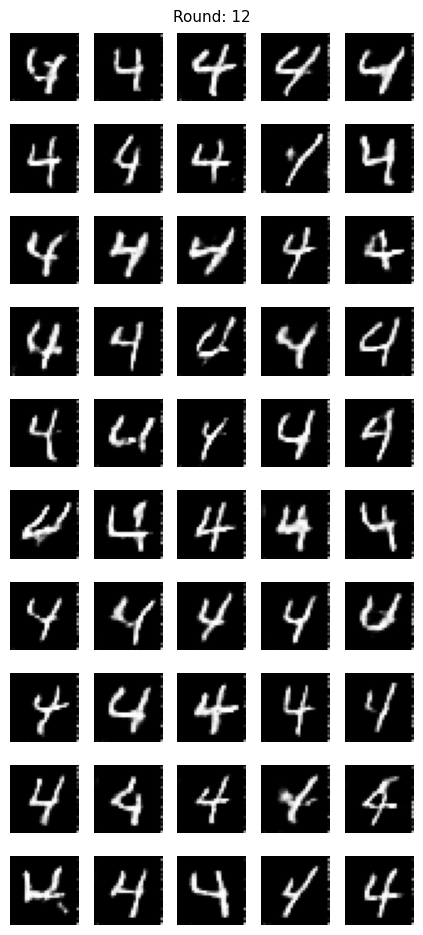

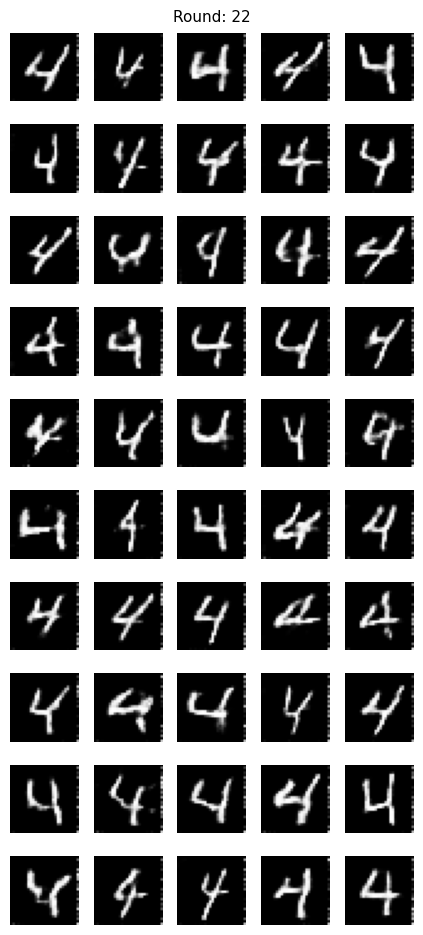

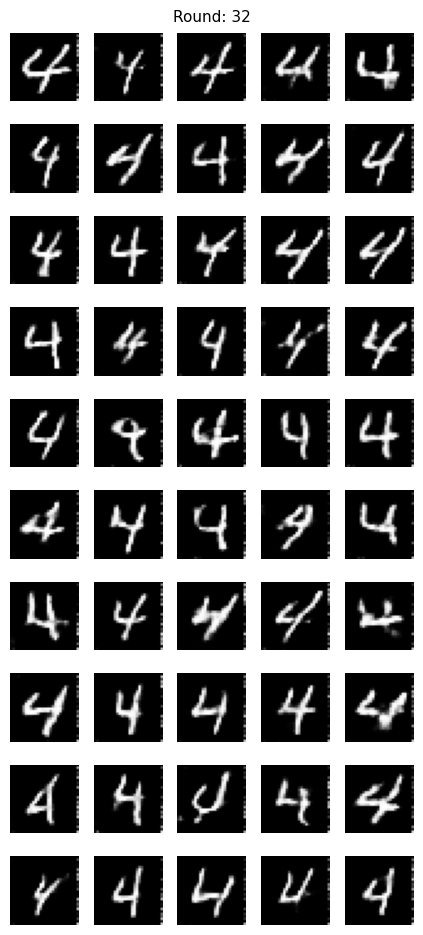

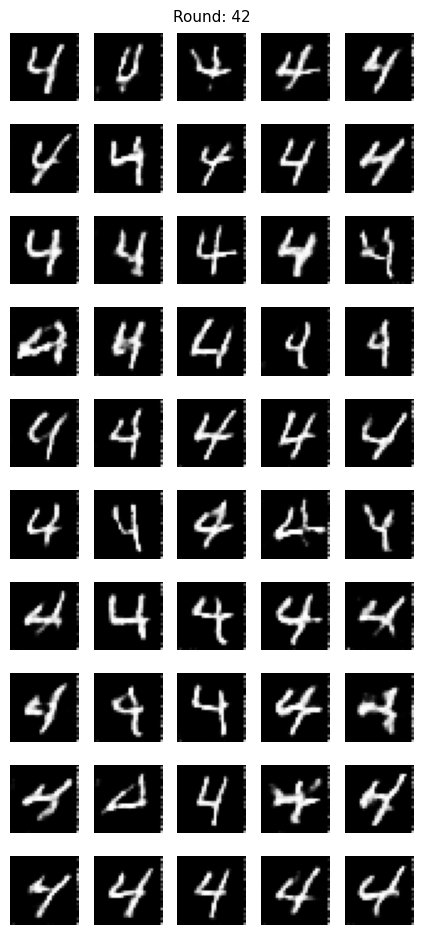

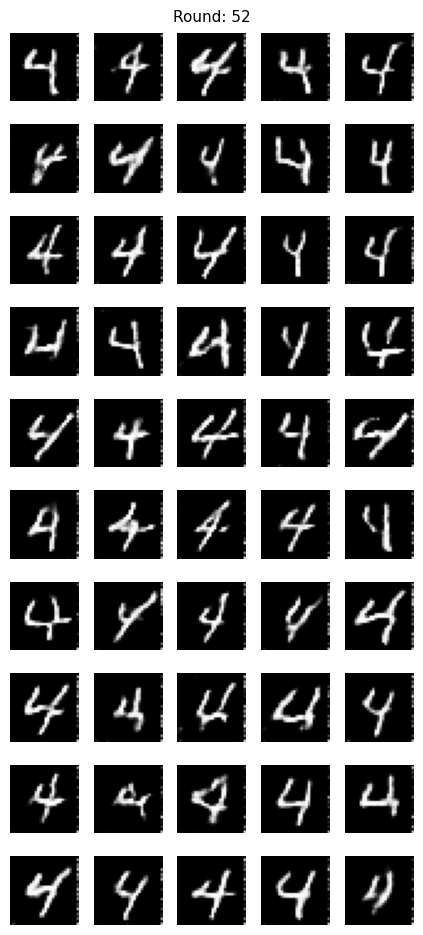

In [45]:
for i in range(2,54,10):
    gen = F2U_GAN(condition=False).to("cpu")
    gen.load_state_dict(torch.load(f"gen_round{i}.pt"))
    plot_unconditional_generated(gen, "cpu", 50, latent_dim=128, round_number=i)